In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastcore.all import *
from fastdownload import download_url

## Step 1: Download images of the Beatles using DuckDuckGo

In [2]:
from duckduckgo_search import ddg_images

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

We save images in 'searches' to train the model. We remove images which didn't download correctly.

In [3]:
searches = 'John Lennon', 'Paul McCartney', 'Ringo Starr', 'George Harrison'
path = Path('the_Beatles')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}', 150))
    sleep(10)  # Pause between searches to avoid over-loading server
    #resize_images(path/o, max_size=400, dest=path/o)

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

Searching for 'John Lennon'
Searching for 'Paul McCartney'
Searching for 'Ringo Starr'
Searching for 'George Harrison'


19

## Step 2: Augment the data

We use a 'Datablock' to separate the data into training and validation sets.

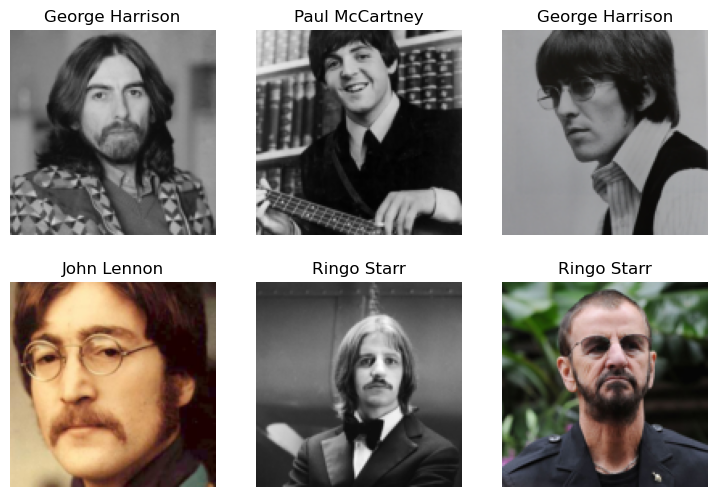

In [4]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = data.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=2)

Pad the images with black:

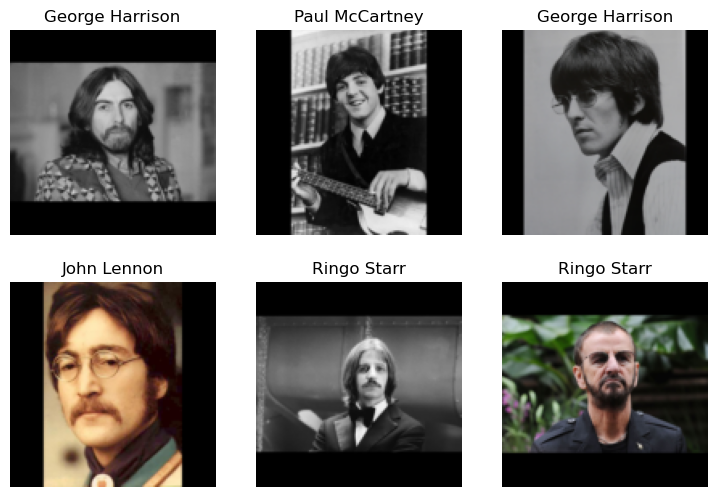

In [5]:
data=data.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = data.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=2)

Squish the images:

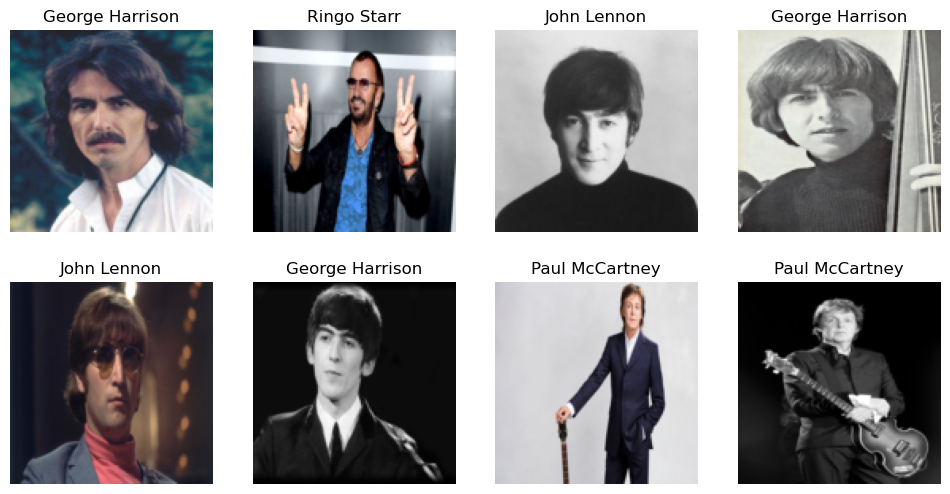

In [6]:
data.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = data.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2)

Transform with Random Resized Crop:

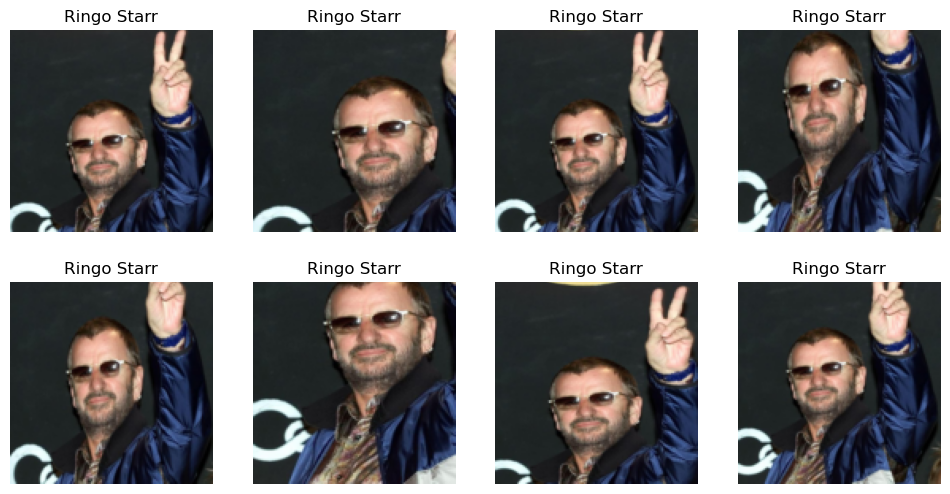

In [7]:
data.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = data.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Example of data augmentation using aug_transforms:

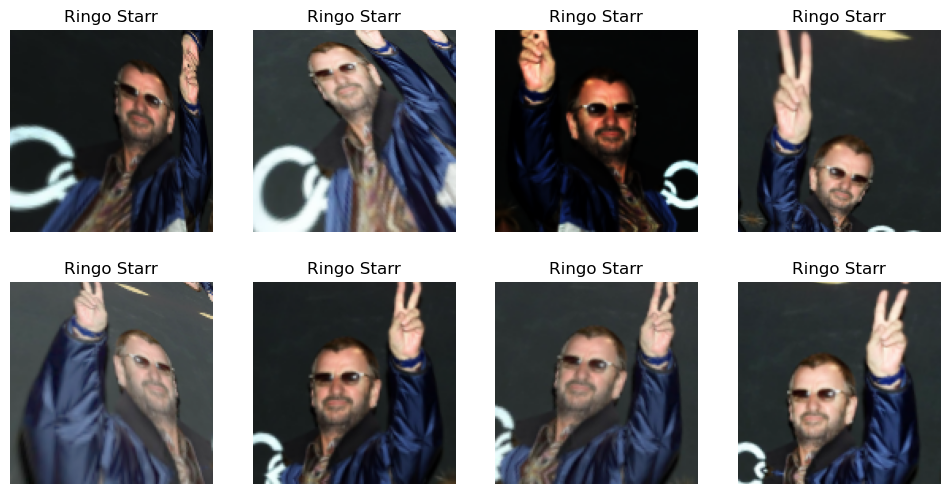

In [8]:
data = data.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = data.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Step 3: Train the model and clean some of the data by hand

In [9]:
data = data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = data.dataloaders(path)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.396378,1.538527,0.522936,00:24


epoch,train_loss,valid_loss,error_rate,time
0,1.393517,1.140603,0.440367,00:22
1,1.261823,0.996967,0.357798,00:23
2,1.069076,0.967244,0.339450,00:23
3,0.934776,0.965879,0.348624,00:23


To visualize the mistakes the errors the model makes, we create a confusion matrix.

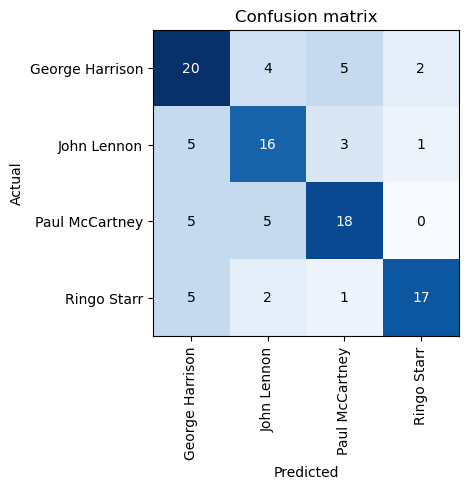

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

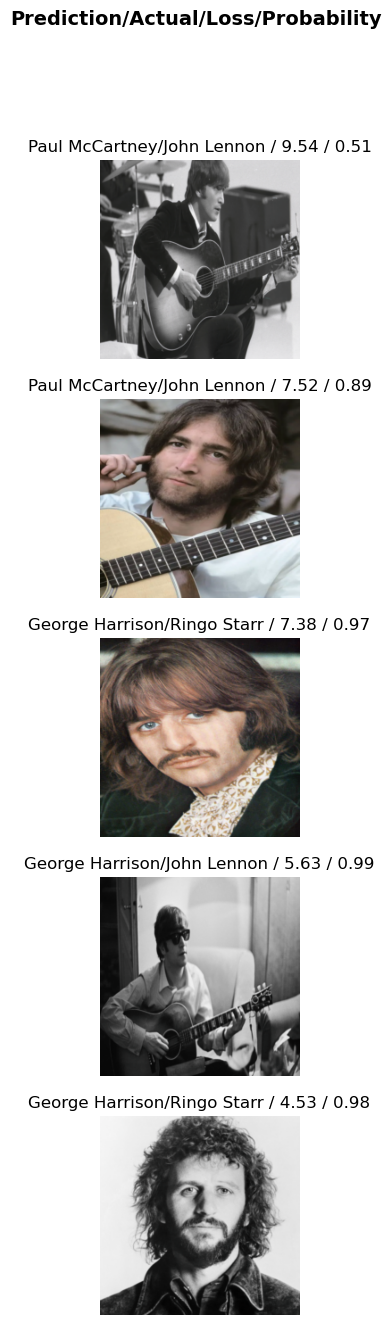

In [12]:
interp.plot_top_losses(5, nrows=5)

## Step 3: Turn the model into an online application

We save the architecure and the learned parameters of our model.

In [13]:
learn.export()

In [14]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

We can then create an inference learner from this exported file.

In [15]:
learn_inf = load_learner(path/'export.pkl')